<img src="PUC.png" width="100" height="100">

# **Modelo para categorizar a decisão em um julgado com base na íntegra de um acórdão proferido pelo CARF**
**Trabalho de Conclusão de Curso - TCC** apresentado como pré-requisito para obtenção do título de especialista no curso MBA BI MASTER BUSINESS INTELLIGENCE MASTER - SISTEMAS INTELIGENTES DE APOIO À DECISÃO EM NEGÓCIOS oferecido pelo Departamento de Engenharia Elétrica e administrado pela Coordenação Central de Extensão da PUC-Rio <br />
Professor Orientador: **Dr. Leonardo Alfredo Forero Mendoza** <br />
Aluno: **Rafael dos Santos - Turma: 2019.2**

**Passo 1 - Conhecimento dos dados** <br />
1.1 - Primeiramente é feito um preparo do ambiente onde estão hospedados os arquivos com os julgados extraídos do site oficial do CARF (https://carf.fazenda.gov.br/sincon/public/pages/ConsultarJurisprudencia/consultarJurisprudenciaCarf.jsf) <br />
1.2 - Em seguida, a importação das principais bibliotecas python utilizadas no processo de conhecimento e pré-processamento dos dados.

In [2]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re

In [3]:
os.chdir("/projetos/UQC6/CARF")

In [4]:
df = pd.read_excel(r'Julgamentos.xlsx', engine='openpyxl')

1.3 - Neste ponto é realizado um pré-processamento da base, abrindo cada documento, tratando espaços e quebras de linha, ajustando a codificação para utf-8 e organizando tudo em um dataframe posteriormente armazenado na variável "data".

In [5]:
def text_preprocessing(text):
  text = text.strip().replace('\n','')
  text = re.sub(' +', ' ', text)
  return text

def read_text(row):
  with open(row['Documento'],'r', encoding='utf-8') as file:
    text = text_preprocessing(file.read())
  return text

df['text'] = df.apply(lambda row:read_text(row), axis=1)
data = df[['text','Provimento']]

In [6]:
data.head(3)

,text,Provimento
0,DF CARF MFFl. 1922 1 S2­C4T2 Processo nº Rec...,NEGADO
1,DF CARF MFFl. 251 1 S2­C4T2 Processo nº Recu...,NEGADO
2,DF CARF MF 482 S2­C4T2 CÓPIAProcesso nº Recu...,SIM INTEGRAL


In [7]:
data.tail(3)

,text,Provimento
219,DF CARF MF S3-C2T1 Ministério da Economia Cons...,SIM PARCIAL
220,DF CARF MF 998 S1­C3T1 Processo nº Recurso n...,SIM PARCIAL
221,DF CARF MFFl. 60 1 S1­C4T2 Processo nº Recur...,SIM PARCIAL


In [ ]:
print(data.iloc[1,0])

1.4 - Neste ponto é retirada a classe que não interessa ao classificador. São processos em que o contribuinte aderiu a algum tipo de conciliação judicial, administrativa ou REFIS e decidiu não prosseguir com a demanda no CARF.

In [9]:
filtro = data['Provimento'] != "DESISTENCIA" #retirando os julgados com a homologação de desistência
data = data[filtro]

In [10]:
data[data['Provimento'] == "NEGADO"].count()["Provimento"]

70

In [11]:
#n = 0
#for index, row in data.iterrows():
  #if row.Provimento == "NEGADO" and n < 31:
    #n = n + 1    
  #if row.Provimento == "NEGADO" and n > 30:
    #data.drop(index, inplace=True)
    #n = n + 1

In [12]:
#data[data['Provimento'] == "NEGADO"].count()["Provimento"]

1.5 - Neste ponto verificamos o tamanho da base, a distribuição dos rótulos e algumas estatísticas dos dados. Foram carregados 210 julgados, rotulados manualmente, sendo 70 de cada classe (NEGADO, SIM INTEGRAL e SIM PARCIAL).

In [13]:
len(data.index)

210

<AxesSubplot:xlabel='Provimento', ylabel='count'>

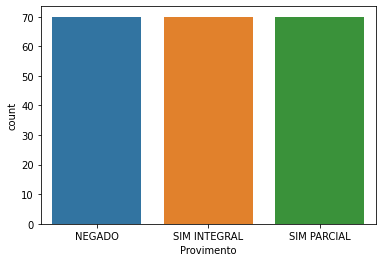

In [14]:
# inspect provimentos
sns.countplot(data['Provimento'])

In [15]:
# text length
data['text_length'] = df['text'].apply(len)
data[['text_length','text']].head(1)

,text_length,text
0,66714,DF CARF MFFl. 1922 1 S2­C4T2 Processo nº Rec...


In [16]:
data['text_length'].describe()

count       210.000000
mean      33637.566667
std       28542.970237
min        3426.000000
25%       14675.250000
50%       27966.500000
75%       45094.500000
max      272427.000000
Name: text_length, dtype: float64

<AxesSubplot:>

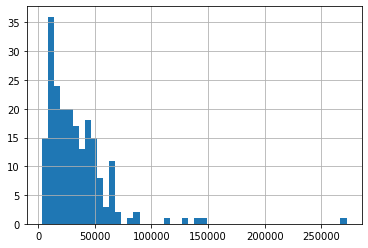

In [17]:
data['text_length'].hist(bins=50)

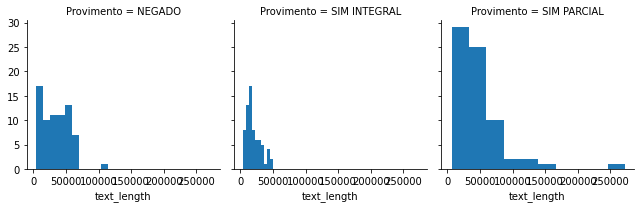

In [18]:
g = sns.FacetGrid(data,col='Provimento')
g.map(plt.hist,'text_length')

**Passo 2 - Limpeza dos dados**

In [ ]:
# LIMPEZA DOS DADOS - Importando as bibliotecas necessárias

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

2.1 - Extraindo algumas palavras que se repetem no cabeçalho de todos os documento e não contribuem para a classificação pelo modelo.

In [ ]:
# Limpando os dados
from textwrap import TextWrapper
stopwords = nltk.corpus.stopwords.words('portuguese')

def limpar(s):
    s = s.strip().lower()
    s = re.sub(r'julgamento', '', s)
    s = re.sub(r'digitalmente', '', s)
    s = re.sub(r'carf', '', s) 
    s = s.strip()
    s = nltk.tokenize.word_tokenize(s)
    s = [word for word in s if not word in stopwords]
    s = ' '.join(s)
    return s


data['clean_text'] = data['text'].apply(limpar)
text = data.iloc[1]['clean_text']
TextWrapper(max_lines=20).wrap(text)

2.2 - Neste ponto é feito o recorte dos extremos da base. Conta-se a frequência das palavras e extrai-se aquelas com baixa e alta frequência.

In [104]:
from collections import Counter
from itertools import chain

# dividir palavras em listas
v = data['clean_text'].str.split().tolist() 
# computar frequência global de palavras
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
data['clean_text'] = [' '.join([j for j in i if c[j] > 2 and c[j] < 1000]) for i in v]
v1 = data['clean_text'].str.split().tolist() 
c1 = Counter(chain.from_iterable(v))
a = sorted(c1.items(), key=lambda x: x[1]) #aqui eu ordeno os resultados em ordem crescente de frequência    
#print(a)

2.3 - Neste ponto utilizamos o spacy, uma biblioteca de software de código aberto para processamento avançado de linguagem natural, para remover palavras curtas, pontuações, stop words e realizar a lematização de toda base de julgados.

In [ ]:
# Instantiate a spaCy object
!pip install deplacy
#!python -m spacy download pt_core_news_sm
import pkg_resources,imp
imp.reload(pkg_resources)
import spacy
import string

import pt_core_news_sm
nlp = pt_core_news_sm.load()

# Regular expressions
remove_num = re.compile(r'\d+')
remove_duplicates = re.compile(r'\b(\w+)(?:,\s+\1\b)+', flags=re.I)

# Load punctuation
punctuation = string.punctuation

def preprocess_text(s):    
    
    # Apply compiled regular expressions
    s = remove_duplicates.sub(' ', s)
    s = remove_num.sub(' ', s)
    
    # Remove traiiling spaces
    s = re.sub(r'\s+', ' ', s)   
    
    # Create a spaCy doc
    doc = nlp(s, disable=['tagger', 'parser', 'ner'])
     
    # Remove punctuations and small words 
    tokens = [token for token in doc if not token.is_punct and len(token) > 3]

    # Remove stop words and non-alphabetic words
    tokens = [token for token in tokens if not token.is_stop and token.is_alpha]

    # Lemmatizer and lowercase
    tokens = [token.lemma_.lower() if token.lemma_ !='-PRON-' 
              else token.lower_ for token in tokens]    

    return ' '.join(tokens)

In [106]:
%%time
data['clean_text'] = data['clean_text'].apply(preprocess_text)

CPU times: user 23.2 s, sys: 32.9 ms, total: 23.3 s
Wall time: 23.3 s


In [ ]:
text = data.iloc[1]['clean_text']
TextWrapper(max_lines=20).wrap(text)

In [108]:
# Verificando o tamanho dos julgados limpos
data['TextLength'] = data['clean_text'].apply(len)
data['TextLength'].describe()

count       210.000000
mean      16399.904762
std       13608.744550
min        1154.000000
25%        6831.750000
50%       13980.500000
75%       22478.000000
max      122155.000000
Name: TextLength, dtype: float64

<AxesSubplot:>

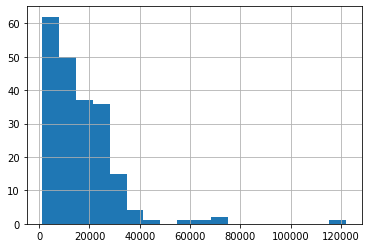

In [109]:
# Verificando a distribuição dos comprimentos

bins = 18
data['TextLength'].hist(bins=bins)

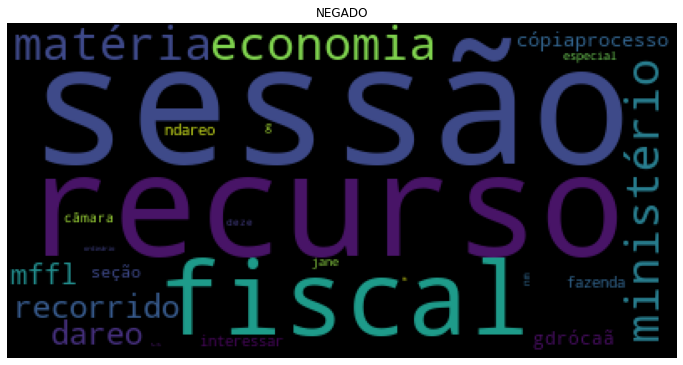

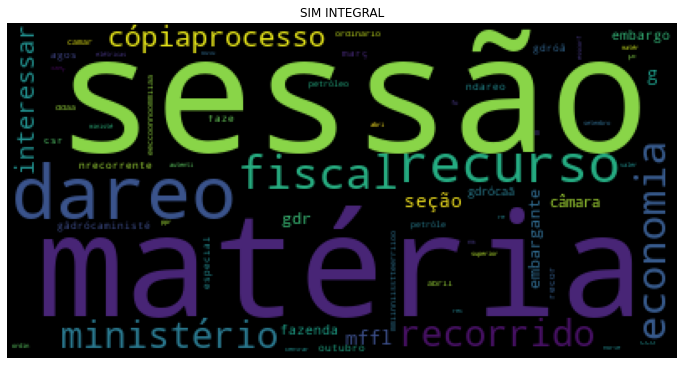

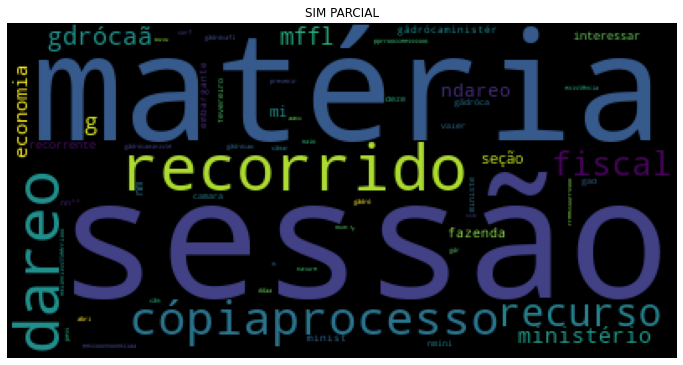

In [110]:
# Gerando uma nuvem de palavras por classe

classes = data['Provimento'].unique()

for classe in classes:
  text = data[data['Provimento']==classe]['clean_text'].to_string()

  wordcloud = WordCloud(#background_color='gray',colormap='Oranges_r',
      collocations=False,
      relative_scaling=0.5,
     # max_words=100,
      stopwords=set(stopwords)).generate(text)

  plt.figure(figsize=(12,12))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(classe)
  plt.show()

In [112]:
# dividir palavras em listas
v = data['clean_text'].str.split().tolist() 
# computar frequência global de palavras
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
data['clean_text'] = [' '.join([j for j in i if c[j] > 2 and c[j] < 1000]) for i in v]
v1 = data['clean_text'].str.split().tolist() 
c1 = Counter(chain.from_iterable(v))
a = sorted(c1.items(), key=lambda x: x[1]) #aqui eu ordeno os resultados em ordem crescente de frequência    
#print(a)

Words Frequency Distribution </br>
Tokenizando e verificando a frequência das palavras após o tratamento da base.

In [113]:
from pprint import pprint
from nltk.tokenize import TweetTokenizer

In [114]:
tt = TweetTokenizer()
corpus = ' '.join([*data['clean_text']])
freq_dist = nltk.FreqDist(tt.tokenize(corpus))

In [ ]:
pprint(freq_dist.most_common(100), compact=True)

**Passo 3 - Pré-processamento**

In [116]:
# Importando bibliotecas necessárias

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

In [117]:
# Verificando se a limpeza deixou algum documento vazio

data.clean_text[data['clean_text'] == ''].count()

0

In [118]:
# Codificando as classes categóricas de provimento dos julgados

le = LabelEncoder()
le.fit(data['Provimento'])
classes = le.classes_
num_classes = len(classes)
classes

array(['NEGADO', 'SIM INTEGRAL', 'SIM PARCIAL'], dtype=object)

In [119]:
# Encode Categorical Variable
X = data['clean_text']
y = le.transform(data['Provimento'])
#y = pd.get_dummies(data['Provimento']).values
y

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1,
       0, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [120]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [121]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(189,) (21,) (189,) (21,)


In [122]:
# Tokenizando o texto
#20000
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

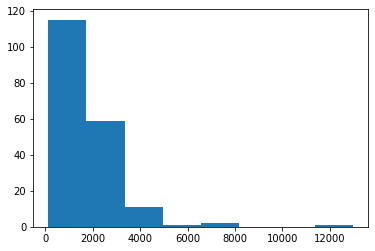

12967

In [123]:
# Verificando o número de palavras

words = [len(julgado) for julgado in X_train]
plt.hist(words,bins = 8)
plt.show()
max(words)

In [124]:
# Completando o tamanho para todos os documentos ficarem iguais

#X_train = sequence.pad_sequences(X_train, maxlen=max(words))
#X_test = sequence.pad_sequences(X_test, maxlen=max(words))
X_train = sequence.pad_sequences(X_train, maxlen=7000)
X_test = sequence.pad_sequences(X_test, maxlen=7000)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(189, 7000) (21, 7000)
(189,) (21,)


**Passo 4- Classificação**

Passo 4.1 - CNN-LSTM

In [125]:
# Importando as bibliotecas necessárias

from tensorflow import random
import numpy as np

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense,Embedding,Conv1D,GlobalMaxPool1D,LSTM, Bidirectional, MaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.utils import class_weight
from keras.optimizers import SGD

Definindo o modelo

In [126]:

# Função que cria o modelo de categorização

def get_model(max_features, embed_dim):

    np.random.seed(7)
    random.set_seed(7)
    K.clear_session()

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))    
    model.add(LSTM(140,return_sequences = True)) #140
    model.add(LSTM(140, dropout=0.2, recurrent_dropout=0.2)) #140
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    
    return model

In [127]:
# Definindo função que treina o modelo

def model_train(model):

    ES = EarlyStopping(patience=5,monitor="val_loss", mode='auto', restore_best_weights=True)
    RLR = ReduceLROnPlateau(monitor='val_acc', patience = 5, verbose=2,factor=0.5, min_lr=0.00001)
    #SM = ModelCheckpoint('desafio_NLP_1.h5', save_best_only=True),

    #class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
    
    model_history = model.fit(X_train, y_train, validation_split=0.2, #validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[ES,RLR]
                          #,class_weight=class_weights
                          )
 
    plot_model_history(model_history)

Gráficos e medidas de desempenho

In [128]:
# Definindo função que exibe a evolução do modelo

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Avaliação do modelo

In [129]:
# Definindo função que testa e plota o resultado do modelo

def model_evaluate(): 
    # Recupernaod o modelo com o melhor resultado de validação
    #model = load_model('desafio_NLP_1.h5')

    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(y_test, y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Regras de treinamento

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7000, 100)         600000    
_________________________________________________________________
lstm (LSTM)                  (None, 7000, 140)         134960    
_________________________________________________________________
lstm_1 (LSTM)                (None, 140)               157360    
_________________________________________________________________
dense (Dense)                (None, 256)               36096     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 929,187
Trainable params: 929,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
2/2 [==============================] - 30s 15s/step - loss: 1.0983 - acc: 0.2980 - val_loss: 1.103

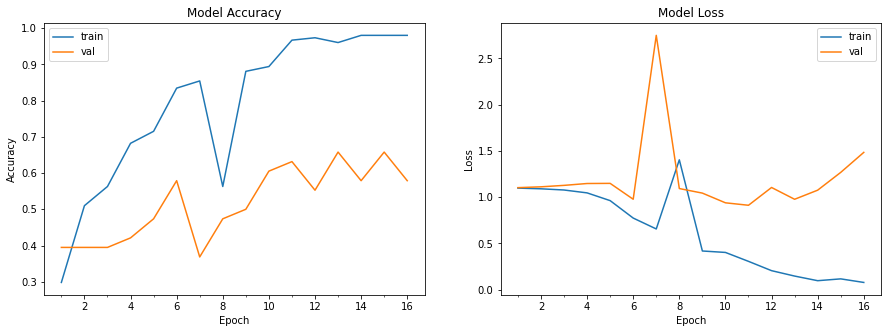

In [130]:
# Treinando o modelo

batch_size = 128 #128 #64
epochs = 1000
max_features = 6000
embed_dim = 100 #100

model = get_model(max_features, embed_dim)
model_train(model)

Avaliar modelo

Accuracy:	85.7%


              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.86      0.86      0.86         7
           2       0.75      0.86      0.80         7

    accuracy                           0.86        21
   macro avg       0.87      0.86      0.86        21
weighted avg       0.87      0.86      0.86        21



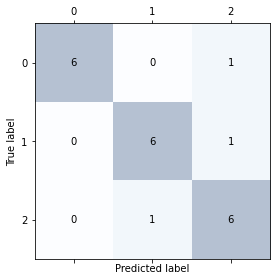

In [131]:
# evaluate model with test set
model_evaluate()

In [ ]:
model.save('meu_modelo')
#Salvando o modelo treinado
#%pwd

In [ ]:
from tensorflow import keras
model3 = keras.models.load_model('meu_modelo') # Carregando o modelo treinado em uma variável

In [ ]:
#model_evaluate(model3)

In [ ]:
model3.predict(X_test[0:1]) #Testando o modelo treinado no primeiro registro da tabela de julgados
#X_test[0:1]

**5 - CONCLUSÕES**

5.1 - Após dezenas de testes e mudanças de parâmetros, a melhor acurácia obtida foi de **85,7%** considerando o modelo utilizando RNN com duas LSTM de 140 neurônios cada; <br />
5.2 - Foram necessárias 16 epochs de treinamento, batch size de 128 e embed dim de 100;<br />
5.3 - Houve piora dos resultados em abordagens utilizando o GLOVE de s50 e s100.<br />


**6 - RECOMENDAÇÕES PARA TRABALHOS FUTUROS**

6.1 - Ampliar a base de dados para obter resultados nos treinamentos ainda mais promissores; <br />
6.2 - Criar um Repositório de Word Embeddings em português, especializado em matéria jurídico tributária a fim de avaliar seu impacto na obtenção de melhores resultados de treinamento; <br />
6.3 - Desenvolver um serviço que faça a extração automática de novos julgados diretamente da base pública do CARF; <br />
6.4 - Desenvolver API para que o modelo seja consumido em aplicações terceiras, auxiliando gestores fiscais na tomada de decisão baseada em dados.

<img src="modelo CARF.png">